# Exercise

### Environment setup and variable definition

The following payload sizes (considered with header size) will be used to compute the calculations

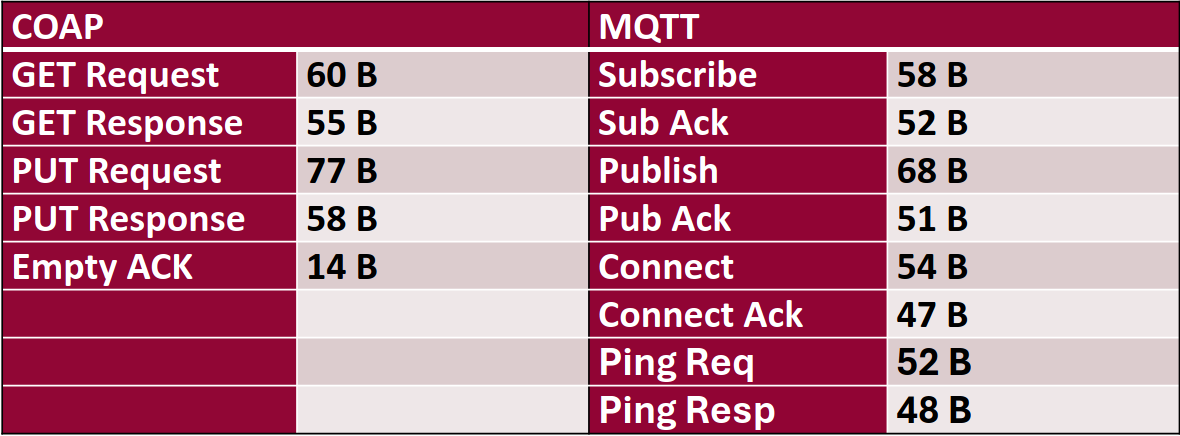

In [104]:
import math
from IPython.display import Image, display

display (Image("./Report/energy_costs.png"))

In [105]:
txFrequence = 5     #minutes
valveFrequence = 30 #minutes
totalTime = 1440    #minutes

dailySensorTransmission = totalTime/txFrequence
dailyValveAveraging = totalTime/valveFrequence

topicLength = 10    #Bytes
payloadLength = 8   #Bytes

EnergyTX = 50       #nJ/bit
EnergyRX = 58       #nJ/bit
EnergyAVG = 2.4     #mJ

coapGetRequest = 60 * 8 #bit
coapGetResponse = 55 *8 #bit

mqttConnect = 54 * 8 #bit
mqttConnectAck = 47 * 8 #bit

mqttSubscribe = 58 * 8 #bit
mqttSubscribeAck = 52 * 8 #bit

mqttPublish = 68 * 8 #bit

### Assumptions  

The assumptions made for this exercise are:
1.   WI-FI network is ideal (no losses)
2.   Sensor and valve start in power-off state



## Exercise Question 1 (EQ1)

Compute the total energy consumed by the two battery-powered devices over a period of 24 hours in both cases when using CoAP (a) and MQTT (b), using each in its most efficient configuration energy-wise.

### EQ1.a

Since the aim is to implement the most energy-efficient configuration under the assumption of operating in a reliable network, it's possible to use Non-Confirmable messages for communication.
It's also possible to use **Observer** mode in order to make the valve send a single Get Request to the sensor to let it know to send updates whenever they are available, that will be every 5 minutes in this specific case.

#### Sensor Energy Consumption

Sensor's energy consumption mainly depends by transmitting temperature updates and by receiving the first GET request from the valve:

In [106]:
EnergyFirstReception = EnergyRX*coapGetRequest

EnergySensorTX = EnergyTX*coapGetResponse #nJ
EnergySensor=(EnergySensorTX*dailySensorTransmission + EnergyFirstReception)*1e-6 #nJ
print("Energy consumed by the sensor is", EnergySensor, "mJ")

Energy consumed by the sensor is 6.36384 mJ


#### Valve Energy Consumption

Valve's energy consumption mainly depends by receiving packets from the sensor and computing their average. This sequence of action happens every 30 minutes

In [107]:
EnergyFirstTransmission = EnergyTX*coapGetRequest

EnergyValveRX = EnergyRX*coapGetResponse #nJ
EnergyValveForReceiving = EnergyValveRX*dailySensorTransmission #nJ

EnergyToAverage= EnergyAVG*dailyValveAveraging #mJ

totEnergyValve = (EnergyValveForReceiving + EnergyFirstTransmission)*1e-6 + EnergyToAverage
print("Energy consumed by the valve is", totEnergyValve, "mJ")

Energy consumed by the valve is 122.57376 mJ


Total energy consumption from both sensor and valve is:

In [108]:
tot = EnergySensor + totEnergyValve

print(tot)

128.9376


#### Answer: 128.94 mJ

### EQ 1.B

In order to solve the second part of the question, MQTT protocol will be used.
Defined the Raspberry PI as the broker, a QOS-0 will be used because of the assumption of network reliability.

### Valve Energy Consumption

In [109]:
ConnectionEnergy = EnergyTX*mqttConnect + EnergyRX*mqttConnectAck           #Energy used to connect to the broker
SubscribeEnergy = EnergyTX*mqttSubscribe + EnergyRX*mqttSubscribeAck        #Energy used to subscribe to the topic

ReceiveDataFromTopicEnergy = EnergyRX*mqttPublish*dailySensorTransmission   #Energy used to receive the message published by the sensor
EnergyToAverage= EnergyAVG*dailyValveAveraging  #mJ                         #Energy used from the valve to average the data

totValveEnergy = (ConnectionEnergy + SubscribeEnergy + ReceiveDataFromTopicEnergy)*1e-6+EnergyToAverage
print("Valve's energy consumption is", totValveEnergy, "mJ")

Valve's energy consumption is 124.37771199999999 mJ


### Sensor Energy Consumption

In [110]:
ConnectionEnergy = EnergyTX*mqttConnect + EnergyRX*mqttConnectAck

PublishOnTopicEnergy= EnergyTX*mqttPublish*dailySensorTransmission

totSensorEnergy = (ConnectionEnergy + PublishOnTopicEnergy)*1e-6
print("Sensor's energy consumption is", totSensorEnergy, "mJ")

Sensor's energy consumption is 7.877008 mJ


### Total energy consumption

In [111]:
tot = totValveEnergy + totSensorEnergy

print("Total energy consumption is:", tot, "mJ")

Total energy consumption is: 132.25472 mJ


## Exercise Question 2 (EQ2)

Propose at least one solution for decreasing th energy consumption when passing using the Raspberry PI as a broker. Give a rough estimate of the energy saving that could be obtained with your solution: recompute the energy under your proposed configuration.

### Alternative 1

Reduce sensor's sampling rate in order to send less data:

In [112]:
a1_sensorTXFrequence = 10 #minutes
a1_dailySensorTransmission = totalTime/a1_sensorTXFrequence

a1_ReceiveDataFromTopicEnergy = EnergyRX*mqttPublish*a1_dailySensorTransmission   #Energy used to receive the message published by the sensor
a1_totValveEnergy = (ConnectionEnergy + SubscribeEnergy + a1_ReceiveDataFromTopicEnergy)*1e-6+EnergyToAverage

print("Valve's energy consumption for A1 is", a1_totValveEnergy, "mJ")

a1_PublishOnTopicEnergy= EnergyTX*mqttPublish*a1_dailySensorTransmission
a1_totSensorEnergy = (ConnectionEnergy + a1_PublishOnTopicEnergy)*1e-6

print("Sensor's energy consumption for A1 is", a1_totSensorEnergy, "mJ")

print("Total energy saved for A1 is:", tot - (a1_totValveEnergy + a1_totSensorEnergy), "mJ")

Valve's energy consumption for A1 is 119.83422399999999 mJ
Sensor's energy consumption for A1 is 3.9602079999999997 mJ
Total energy saved for A1 is: 8.460288000000006 mJ


## Alternative 2

Data sent from the sensor is collected by the broker, which receives it on a dedicated topi, and then sent in a single burst on valve's own topic every 30 minutes: 

In [113]:
a2_valveUpdateFrequence = 30 #minutes
a2_dailyValveUpdates = totalTime/a2_valveUpdateFrequence

a2_ReceiveDataFromTopicEnergy = EnergyRX*mqttPublish*a2_dailyValveUpdates      #Energy used to receive the message published by the sensor

a2_totValveEnergy = (ConnectionEnergy + SubscribeEnergy + a2_ReceiveDataFromTopicEnergy)*1e-6+EnergyToAverage

print("Valve's energy consumption for A2 is", a2_totValveEnergy, "mJ")
print("Sensor's energy consumption is", totSensorEnergy, "mJ")

print("Total energy saved for A2 is:", tot - (a2_totValveEnergy + totSensorEnergy), "mJ")

Valve's energy consumption for A2 is 116.80523199999999 mJ
Sensor's energy consumption is 7.877008 mJ
Total energy saved for A2 is: 7.572479999999999 mJ


## Alternative 3

Data sent from the sensor is collected by the broker on a dedicated topic, the broker computes the average of received data and sends the result to the valve every 30 minutes:

In [114]:
a3_valveUpdateFrequence = 30 #minutes
a3_dailyValveUpdates = totalTime/a2_valveUpdateFrequence

a3_ReceiveDataFromTopicEnergy = EnergyRX*mqttPublish*a3_dailyValveUpdates      #Energy used to receive the message published by the sensor
a3_EnergyToAverage = 0  #mJ                                                    #The average is now computed by the broker

a3_totValveEnergy = (ConnectionEnergy + SubscribeEnergy + a3_ReceiveDataFromTopicEnergy)*1e-6+a3_EnergyToAverage

print("Valve's energy consumption for A3 is", a3_totValveEnergy, "mJ")
print("Sensor's energy consumption is", totSensorEnergy, "mJ")

print("Total energy saved for A2 is:", tot - (a3_totValveEnergy + totSensorEnergy), "mJ")

Valve's energy consumption for A3 is 1.605232 mJ
Sensor's energy consumption is 7.877008 mJ
Total energy saved for A2 is: 122.77247999999999 mJ
